# <img style="float: left; padding: 0px 10px 0px 0px;" src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Escudo_de_la_Pontificia_Universidad_Cat%C3%B3lica_de_Chile.svg/1920px-Escudo_de_la_Pontificia_Universidad_Cat%C3%B3lica_de_Chile.svg.png"  width="80" /> Series de Tiempo - Tarea Final
**Pontificia Universidad Católica de Chile**<br>
**Semestre 2023-2**<br>
**Profesor:** Jonathan Acosta <br>
**Estudiantes:** Juan Bejarano T., Margarita De Alba, Nathalia Moreno y Jorge Rodriguez D.

---

Comenzamos importando y descargando los paquetes necesarios:

In [1]:
!pip install darts

In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
import pmdarima as pm
from statsmodels.tools.eval_measures import rmse
import statsmodels.api as sm

import warnings

warnings.filterwarnings("ignore")

### Análisis exploratorio

Carguemos ahora el dataset que está almacenado originalmente en un repositorio de github y veamos su contenido:

In [3]:
xlsx_url = 'https://github.com/judbejaranota7/Universidad/raw/main/Bimestre7/Series_de_tiempo/TareaFinal/Arribos_oficina_atencion_2.xlsx'

response = requests.get(xlsx_url)
with open('Arribos_oficina_atencion.xlsx', 'wb') as f:
    f.write(response.content)

df = pd.read_excel('Arribos_oficina_atencion.xlsx', engine='openpyxl')
df

,oficina,year,mes,fecha,arribos
0,CAMINO REAL,2020,9,2020-09-01,190
1,CAMINO REAL,2020,9,2020-09-02,186
2,CAMINO REAL,2020,9,2020-09-03,192
3,CAMINO REAL,2020,9,2020-09-04,222
4,CAMINO REAL,2020,9,2020-09-07,237
...,...,...,...,...,...
726,CAMINO REAL,2023,8,2023-08-25,230
727,CAMINO REAL,2023,8,2023-08-28,171
728,CAMINO REAL,2023,8,2023-08-29,199
729,CAMINO REAL,2023,8,2023-08-30,161


Veamos una descripción de las variables del dataset cargado:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   oficina  731 non-null    object        
 1   year     731 non-null    int64         
 2   mes      731 non-null    int64         
 3   fecha    731 non-null    datetime64[ns]
 4   arribos  731 non-null    int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 28.7+ KB


Todo parece consistente por lo que seguimos adelante. Configuramos ahora la variable fecha para que sea el índice de nuestro dataframe:

In [5]:
df.set_index('fecha', inplace=True)
df.head()

,oficina,year,mes,arribos
fecha,,,,
2020-09-01,CAMINO REAL,2020,9,190
2020-09-02,CAMINO REAL,2020,9,186
2020-09-03,CAMINO REAL,2020,9,192
2020-09-04,CAMINO REAL,2020,9,222
2020-09-07,CAMINO REAL,2020,9,237


Primero, veamos la gráfica de la serie original:

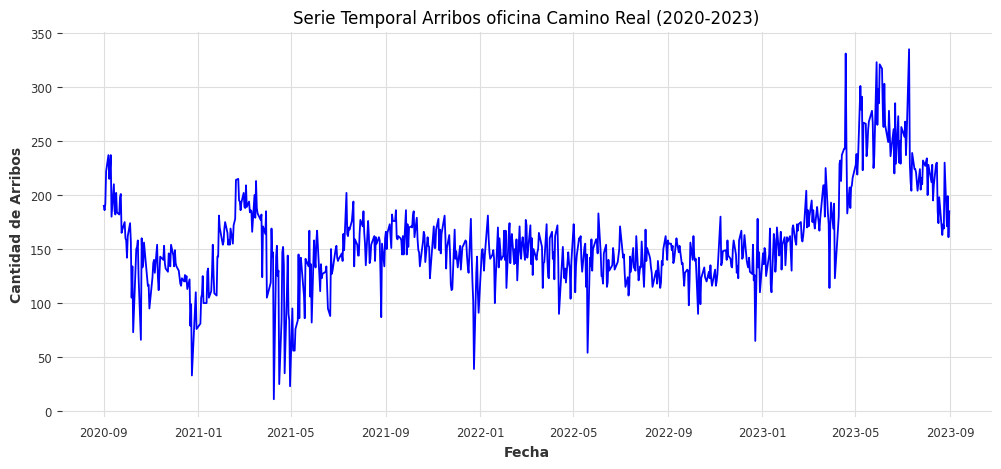

In [6]:
plt.figure(figsize=(12, 5))
plt.plot(df['arribos'], color='blue')
plt.title('Serie Temporal Arribos oficina Camino Real (2020-2023)')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Arribos')
plt.grid(True)
plt.show()

Ahora, construyamos las gráficas ACF y PACF:

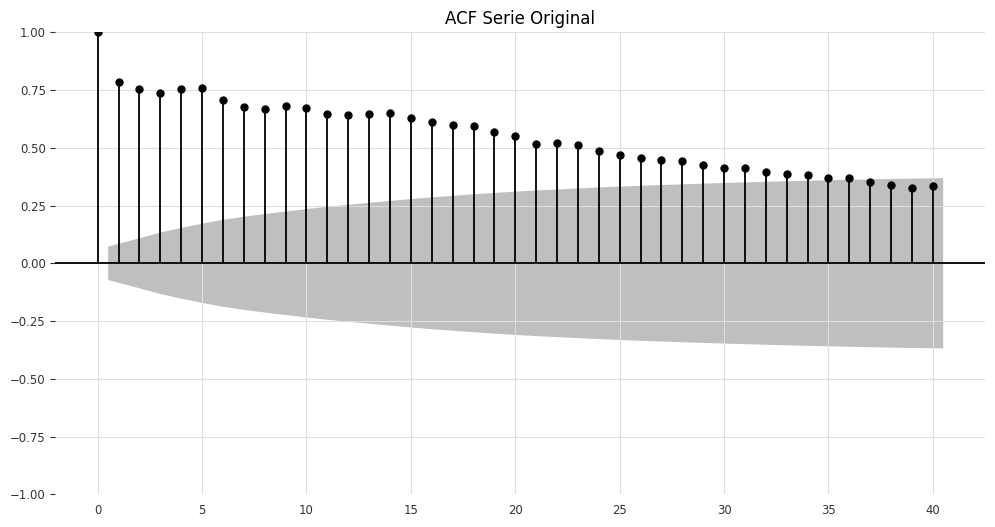

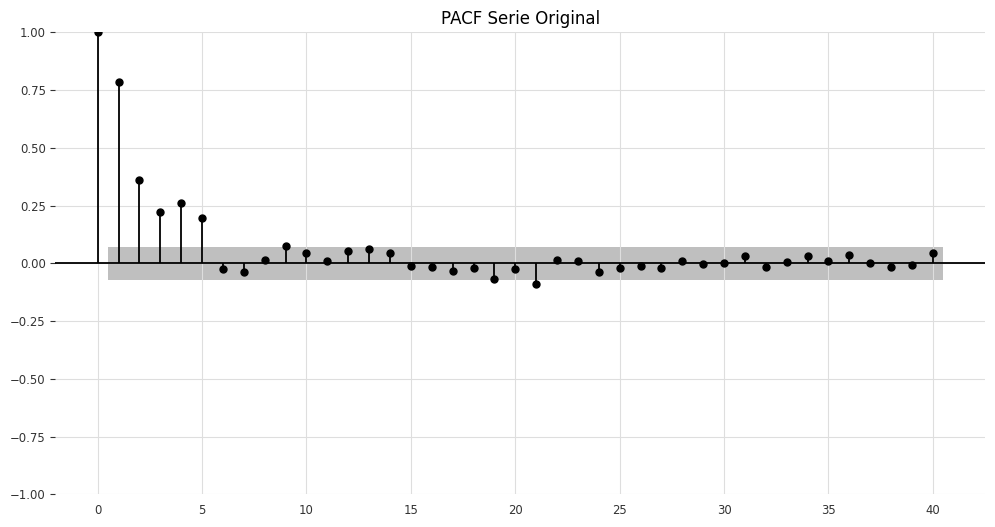

In [7]:
plt.figure(figsize=(12, 6))

# ACF Plot
plot_acf(df['arribos'], lags=40, ax=plt.gca())
plt.title('ACF Serie Original')

plt.figure(figsize=(12, 6))

# PACF Plot
plot_pacf(df['arribos'], lags=40, ax=plt.gca())
plt.title('PACF Serie Original')

plt.show()

De acuerdo con este correlograma de la serie de tiempo original, podemos suponer que la serie no es estacional. Sin embargo, vamos a realizar la prueba de Dickey-Fuller para comprobar si la serie es estacionaria:

In [8]:
df_pd = df[['arribos']]

result = adfuller(df_pd)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -2.960366230736437
p-value: 0.03876514939403705


Resulta curioso encontrar que en la prueba de Dickey-Fuller la serie original si es estacionaria, al ser el valor $p$ menor a 0.05 y en contraste, en el gráfico ACF, vemos que los rezagos caen lentamente.

Descompongamos en factores la serie original antes de pasar a la serie diferenciada:

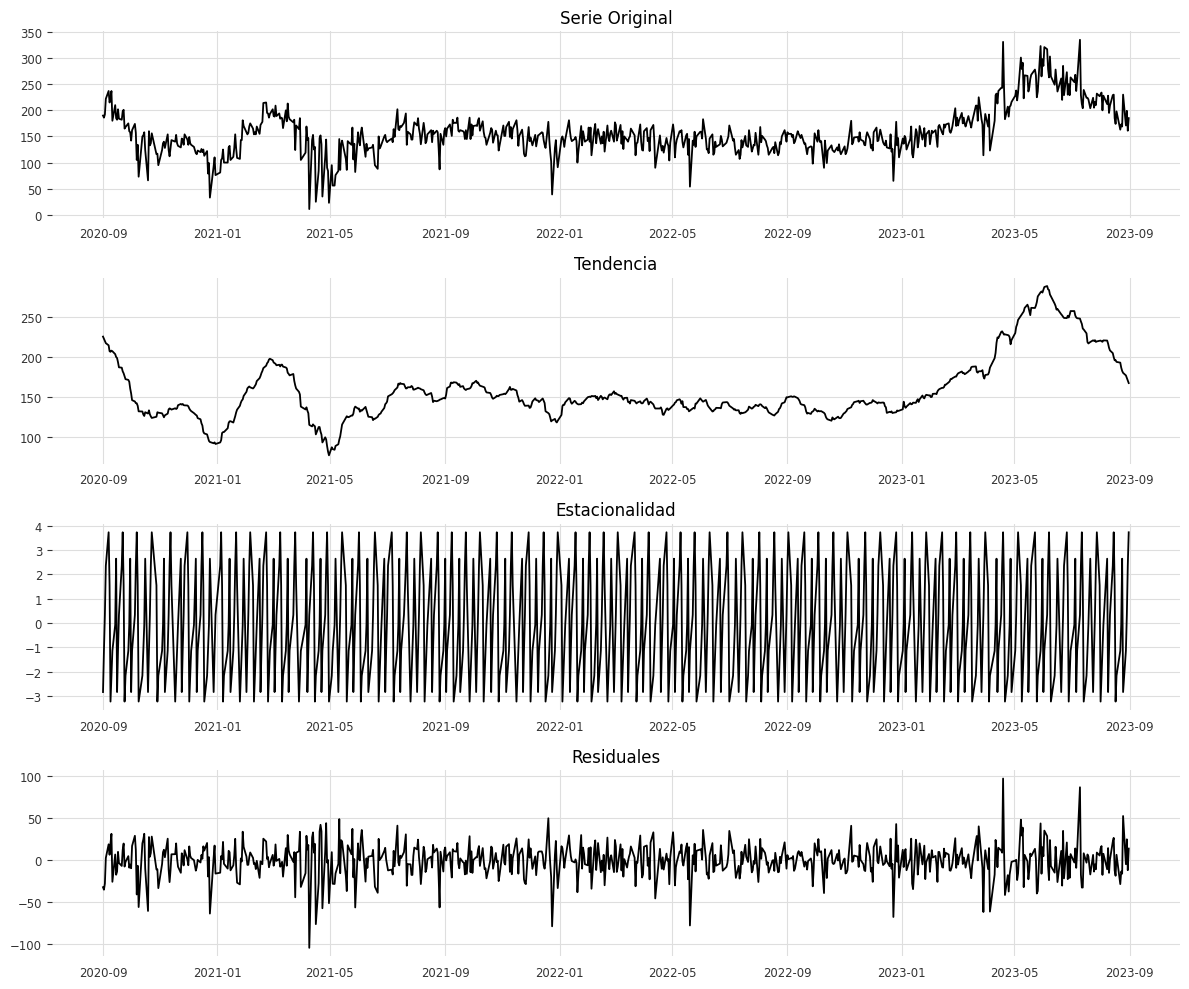

In [9]:
# Se realiza la descomposicón aditiva de la serie de tiempo
result = seasonal_decompose(df['arribos'], model='additive', extrapolate_trend='freq',  period=11)

# Se grafica la serie original junto con su tendencia, estacionalidad y residuales
plt.figure(figsize=(12, 10))
plt.subplot(411)
plt.plot(df['arribos'])
plt.gca().title.set_text('Serie Original')
plt.subplot(412)
plt.plot(result.trend)
plt.gca().title.set_text('Tendencia')
plt.subplot(413)
plt.plot(result.seasonal)
plt.gca().title.set_text('Estacionalidad')
plt.subplot(414)
plt.plot(result.resid)
plt.gca().title.set_text('Residuales')
plt.tight_layout()
plt.show()

Como ya suponiamos, la serie original no muestra una descomposición de factores aceptables para tratar de lanzar modelos ingenuos. Si bien, la componente estacional parece constante y los residuos parecen ser ruido blanco, la componente de tendencia no muestra un comportamiento claro.  Aún así, aplicaremos un modelo de Holt-Winters para analizar el RMSE obtenido más adelante.

### Transformaciones de la serie original

#### Serie logarítmica

Veamos ahora la serie original bajo una transformación logarítmica:

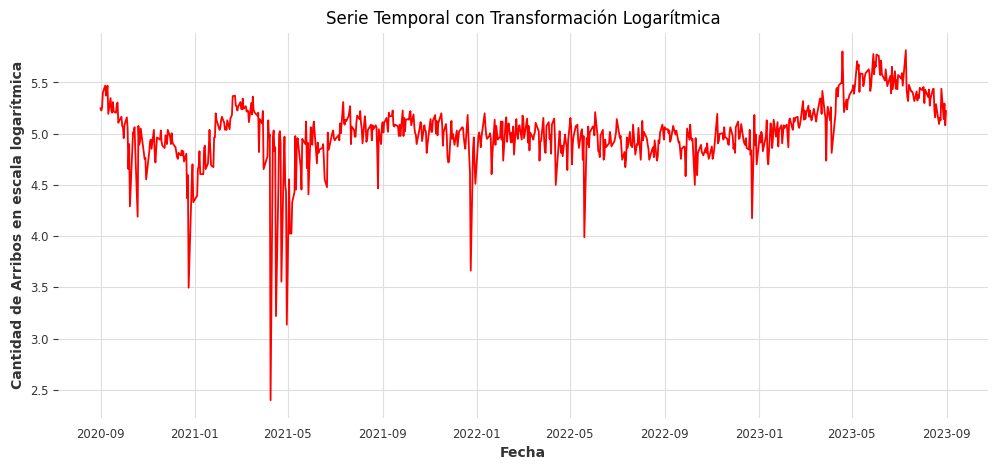

In [10]:
plt.figure(figsize=(12, 5))
plt.plot(np.log(df['arribos']), color='red')
plt.title('Serie Temporal con Transformación Logarítmica')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Arribos en escala logarítmica')
plt.grid(True)
plt.show()

Nos encontramos con que esta serie no luce estacionaria. Intentaremos hacer una transformación de Box-Cox para analizarla.

#### Serie Box-Cox

Veamos la serie original bajo una transformación Box-Cox:

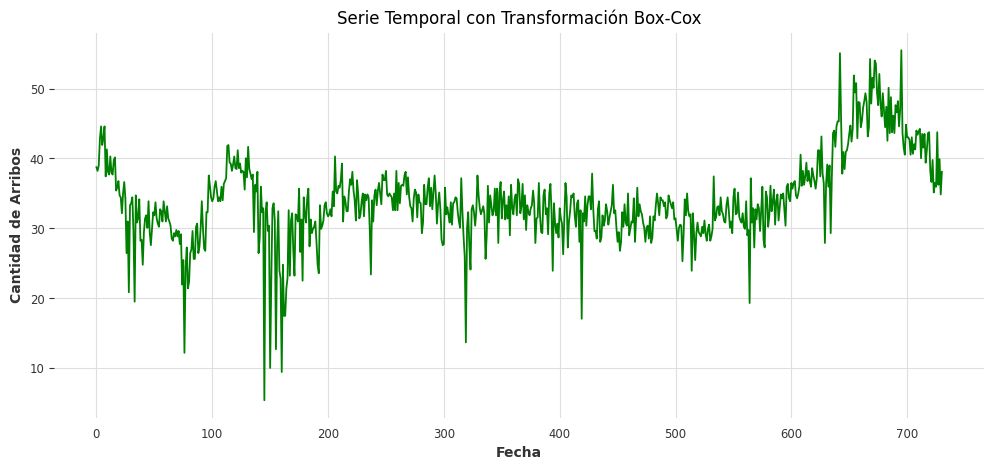

In [11]:
plt.figure(figsize=(12, 5))
boxcox_arribos, _ = boxcox(df['arribos'])
plt.plot(boxcox_arribos, color='green')
plt.title('Serie Temporal con Transformación Box-Cox')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Arribos')
plt.grid(True)
plt.show()

Como conclusión, vemos que la serie que si luce estacionaria, es la serie diferenciada y escalada. Además, lo pudimos comprobar mediante la prueba de Dickey-Fuller. Para los modelos SARIMA, trabajaremos con dicha serie.

#### Serie diferenciada

Haremos un escalamiento, para que nuestros datos se encuentren entre -1 y 1, y luego haremos la diferenciación:

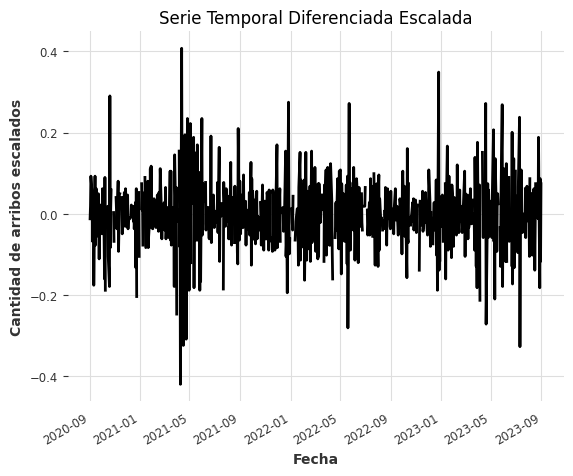

In [12]:
# Creamos una serie de tiempo con los arribos usando Darts
df_ts = TimeSeries.from_series(df_pd.dropna(subset=['arribos']), freq='B',fill_missing_dates=False)

# Diferenciando la serie original y escalandola para tener los resultados entre 0 y 1
scaler = Scaler()
rescaled_df_ts = scaler.fit_transform(df_ts)

df_ts_diff= rescaled_df_ts.diff()

#Graficamos la serie diferenciada escalada
df_ts_diff.plot()

plt.title('Serie Temporal Diferenciada Escalada')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de arribos escalados')
plt.legend().remove()

plt.show()

Ahora comprobemos si esta serie con una diferenciación es estacionaria:

In [13]:
# Convertimos la serie temporal de Darts a una serie de pandas
df_ts_diff_pd = df_ts_diff.pd_series().dropna()

# Realizamos el test de Dickey-Fuller
result = adfuller(df_ts_diff_pd)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -20.231038072801013
p-value: 0.0


A partir de estos resultados, podemos ver que la serie diferenciada es completamente estacionaria y que no existe dependencia temporal en la serie.

Ahora, veamos el correlograma de la serie diferenciada.

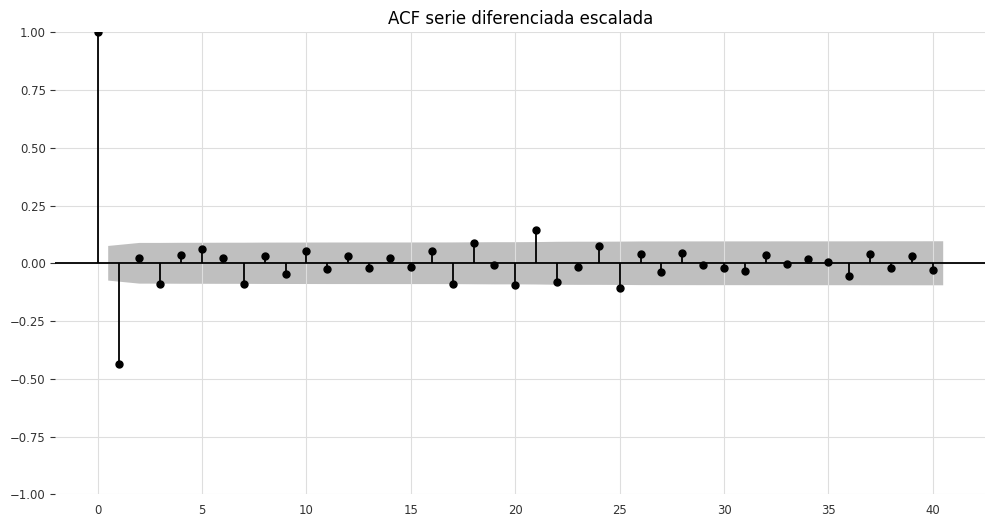

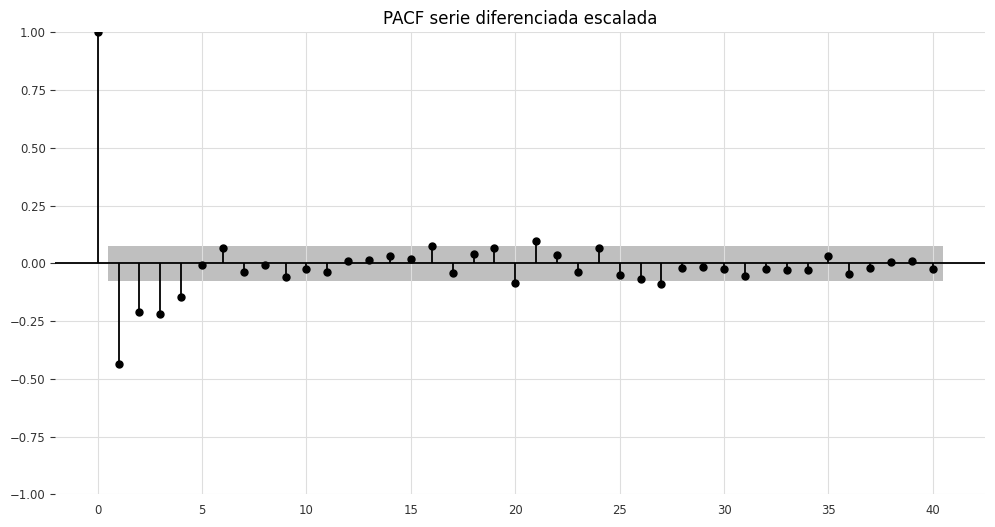

In [14]:
plt.figure(figsize=(12, 6))

# ACF Plot
plot_acf(df_ts_diff_pd, lags=40, ax=plt.gca())
plt.title('ACF serie diferenciada escalada')

plt.figure(figsize=(12, 6))

# PACF Plot
plot_pacf(df_ts_diff_pd, lags=40, ax=plt.gca())
plt.title('PACF serie diferenciada escalada')

plt.show()

En este gráfico resulta curioso ver el rezago 21 como significativo, tanto en el gráfico ACF como PACF. Esto podría deberse a que como los valores son diarios en días hábiles, tal vez corresponda a un ciclo mensual, de alguna estacionalidad en una fecha particular del mes.

A partir del correlograma, podemos inferir que probablemente el modelo contenga AR(1), dado el rezago significativo que tenemos en el gráfico ACF. Así mismo, tal vez tengamos un modelo MA(3) Ó MA(4) debido a los rezagos significativos en el gráfico PACF. Dado que la serie corresponde a datos de días hábiles, podemos llegar a suponer un modelo con un período igual a 5.

### Estudio de modelos

#### Modelo ingenuo

Con la mera curiosidad de comprobar el desempeño de un modelo ingenuo, construimos un modelo de Holt-Winters sobre nuestra serie original:

In [15]:
# Convertimos 'split_date' a un objeto de tipo Timestamp
split_date = pd.Timestamp(datetime.strptime('2023-08-01', '%Y-%m-%d'))

# Se separan los datos en entrenamiento y validación
df_train, df_val = df_ts.split_before(pd.Timestamp(split_date))

# Se convierte la serie temporal de Darts a una serie de pandas
df_train_pd = df_train.pd_series().dropna()
df_val_pd = df_val.pd_series().dropna()

#Se crea una instancia del método
holt_w = ExponentialSmoothing(df_train_pd, seasonal="add", seasonal_periods=5, trend="add")

#Se ajusta el método
holt_w_fit = holt_w.fit()

# Se aplica el método a la muestra de entrenamiento
train_predictions = holt_w_fit.fittedvalues

# Se calcula el MSE de entrenamiento
train_mse = mean_squared_error(df_train_pd, train_predictions)

# Se calculan las constantes de suavizamiento
alpha = holt_w_fit.params['smoothing_level']
beta = holt_w_fit.params['smoothing_trend']
gamma = holt_w_fit.params['smoothing_seasonal']

print("Alpha (Nivel):", alpha)
print("Beta (Tendencia):", beta)
print("Gamma (Estacionalidad):", gamma)
print("RMSE en la muestra de entrenamiento:", np.sqrt(train_mse))

Alpha (Nivel): 0.26125126611420785
Beta (Tendencia): 0.016119212856559786
Gamma (Estacionalidad): 0.03066197635298562
RMSE en la muestra de entrenamiento: 23.77474440472249


In [16]:
# Se obtiene el número de parámetros
num_params = 2

# Si hay componente de tendencia, se agrega 1 al número de parámetros
if holt_w_fit.model.trend is not None:
    num_params += 1

# Si hay componente estacional, se agrega el número de componentes estacionales al número de parámetros
if holt_w_fit.model.seasonal is not None:
    num_params += len(holt_w_fit.model.seasonal)

# Se calcula el logaritmo natural de la función de verosimilitud
log_likelihood = -0.5 * train_mse  # En el caso de mínimos cuadrados

# Se calcula el AIC
aic_holtW = 2 * num_params - 2 * log_likelihood

print("Número de parámetros:", num_params)
print("Log-verosimilitud:", log_likelihood)
print("AIC Holt-Winters:", aic_holtW)

Número de parámetros: 6
Log-verosimilitud: -282.61923575494166
AIC Holt-Winters: 577.2384715098833


In [17]:
validation_predictions = holt_w_fit.forecast(len(df_val_pd))

validation_mse = mean_squared_error(df_val_pd, validation_predictions)

print("RMSE en la muestra de validación:", np.sqrt(validation_mse))

RMSE en la muestra de validación: 33.481646436926724


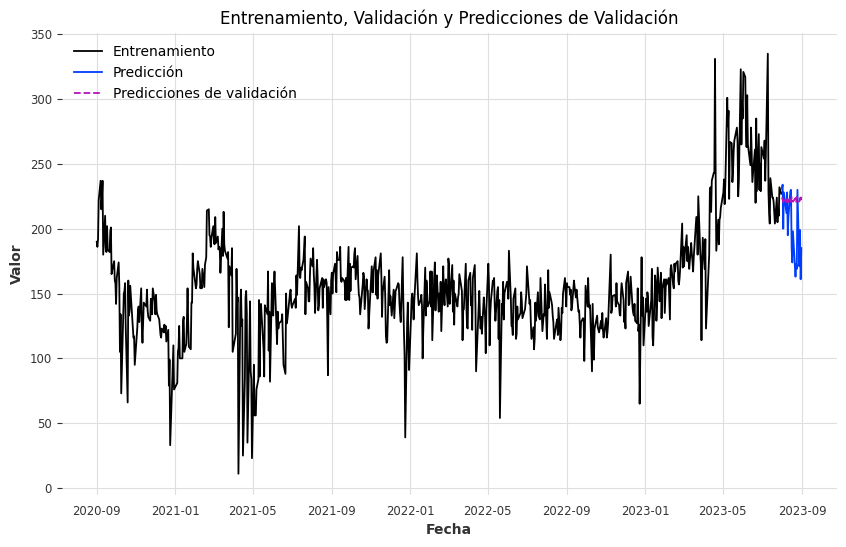

In [18]:
# Graficar serie de entrenamiento y validación
plt.figure(figsize=(10, 6))
plt.plot(df_train_pd.index, df_train_pd, label='Entrenamiento')
plt.plot(df_val_pd.index, df_val_pd, label='Predicción')

# Graficar predicciones de validación
plt.plot(df_val_pd.index, validation_predictions, label='Predicciones de validación', linestyle='--')

plt.title('Entrenamiento, Validación y Predicciones de Validación')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

A partir de los resultados obtenidos, vemos que el modelo ingenuo claramente no predice correctamente frente a los datos de validación.

Procedamos ahora con modelos SARIMA.

#### SARIMA

A partir del análisis exploratorio usaremos la función `auto_arima` de la biblioteca `pmdarima` para encontrar los parámetros óptimos de un modelo ARIMA que se ajuste a los datos de entrenamiento de la serie de arribos escalada y diferenciada.

Para determinar el mejor modelo SARIMA, usaremos como métrica de rendimiento el RMSE:

In [19]:
# Se separan los datos en conjuntos de entrenamiento y validación
df_train_scale, df_val_scale = rescaled_df_ts.split_before(pd.Timestamp(split_date))

#Se diferencia la serie escalada
df_train_diff = df_train_scale.diff()
df_val_diff = df_val_scale.diff()

# Convierte la serie temporal de Darts a una serie de pandas
df_train_diff_pd = df_train_diff.pd_series().dropna()
df_val_diff_pd = df_val_diff.pd_series().dropna()

#Creamos dos listas para guardar los modelos y sus valores de rmse
models=[]
rmses=[]

#Iteramos para distintos valores de m
for m_value in [3,4,5,6]:

  #Determinamos los parametros del mejor sarima y lo guardamos en la lista
  mod=pm.auto_arima(df_train_diff_pd, seasonal=True, stepwise=True,suppress_warnings=True, error_action="ignore",max_order=None, start_p=0, max_p=6,
                    start_q=0, max_q=6,m=m_value)
  models.append(mod)

  #Encontramos las predicciones para el modelo anterior, calculamos el rmse y lo guardamos en la lista
  pred,_=mod.predict(n_periods=len(df_val_diff_pd), return_conf_int=True, alpha=0.05)

  rmses.append(rmse(df_val_diff_pd, pred))

Veamos ahora de forma tabular los resultados obtenidos, considerando un modelo $\text{SARIMA}(p,d,q)(P,D,Q,s)$ con $s\in \{3,4,5,6\}$:

In [20]:
p=[]
d=[]
q=[]
P=[]
D=[]
Q=[]
s=[]

for mod in models:
  p.append(mod.order[0])
  d.append(mod.order[1])
  q.append(mod.order[-1])
  P.append(mod.seasonal_order[0])
  D.append(mod.seasonal_order[1])
  Q.append(mod.seasonal_order[2])
  s.append(mod.seasonal_order[-1])

comp=pd.DataFrame({"p":p,"d":d,"q":q,"P":P,"D":d,"Q":Q,"s":s,"RMSE":rmses})

comp.set_index("s")

,p,d,q,P,D,Q,RMSE
s,,,,,,,
3,0,0,1,1,0,0,0.093957
4,0,0,1,0,0,0,0.094381
5,0,0,1,1,0,0,0.094558
6,0,0,1,0,0,0,0.094381


De acuerdo con las múltiples iteraciones realizadas, el modelo que provee el mejor  RMSE es el SARIMA(0,0,1)(1,0,0,3), con un RMSE de 0.0940 (3 c.s.). Ahora bien, no necesariamente es el que ofrece el mejor AIC, dado que no revisamos esta métrica. Como nuestra métrica principal es el RMSE, escogemos dicho modelo.

### Predicciones

Ya con el mejor modelo seleccionado, veamos primero las predicciones del mismo para el siguiente mes (septiembre de 2023):

In [21]:
rescaled_df = rescaled_df_ts.pd_series()

# Ajustamos la función a los parámetros del mejor modelo
modelo_sarimax = sm.tsa.SARIMAX(rescaled_df,order=(0, 0, 1),seasonal_order=(1, 0, 0, 3),enforce_stationarity=False,enforce_invertibility=False,trend='n')

#Predecimos los valores para el próximo mes (21 días hábiles)
resultado_sarimax = modelo_sarimax.fit()
predicciones = resultado_sarimax.get_forecast(steps=(21))

#Revertimos el escalamiento y mostramos las predicciones
predicciones_acumuladas_ts = TimeSeries.from_series(predicciones.predicted_mean, freq='B', fill_missing_dates=False)
unscaled_preds = scaler.inverse_transform(predicciones_acumuladas_ts).pd_series().dropna()

pd.DataFrame(unscaled_preds).rename(columns={0:'Arribos Predichos'})

,Arribos Predichos
time,
2023-09-01,197.199069
2023-09-04,157.057630
2023-09-05,180.426850
2023-09-06,192.305298
2023-09-07,153.218875
2023-09-08,175.973895
2023-09-11,187.540148
2023-09-12,149.481012
2023-09-13,171.637974


Calculemos ahora los intervalos de confianza para las predicciones:

In [22]:
intervalos_prediccion = predicciones.conf_int()

intervalos_acumuladas_ts = TimeSeries.from_series(intervalos_prediccion['lower y'], freq='B', fill_missing_dates=False)
unscaled_lower_intervals = scaler.inverse_transform(intervalos_acumuladas_ts).pd_series().dropna()

intervalos_acumuladas_ts = TimeSeries.from_series(intervalos_prediccion['upper y'], freq='B', fill_missing_dates=False)
unscaled_upper_intervals = scaler.inverse_transform(intervalos_acumuladas_ts).pd_series().dropna()

Graficamos los resultados anteriores:

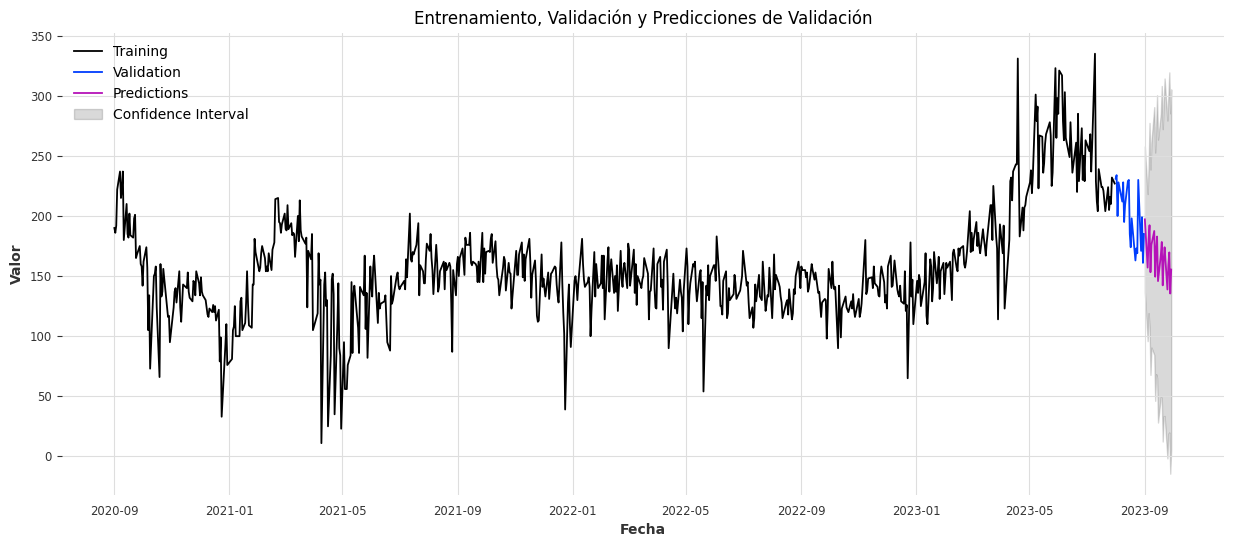

In [23]:
# Graficar serie de entrenamiento y validación
plt.figure(figsize=(15, 6))
plt.plot(df_train_pd.index, df_train_pd, label='Training')
plt.plot(df_val_pd.index, df_val_pd, label='Validation')

# Graficar predicciones de validación
plt.plot(unscaled_preds.index, unscaled_preds, label='Predictions')

# Añadir intervalo de confianza
plt.fill_between(unscaled_lower_intervals.index, unscaled_lower_intervals, unscaled_upper_intervals, color='k', alpha=.15, label='Confidence Interval')

plt.title('Entrenamiento, Validación y Predicciones de Validación')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

In [24]:
print('Min:',np.min(unscaled_preds),'\nMax:',np.max(unscaled_preds),'\nPromedio:',np.mean(unscaled_preds))

Min: 135.48648133205862 
Max: 197.19906916610898 
Promedio: 165.6050041998878
